In [1]:
# data exploration, 눈으로 변수간의 상관관계 먼저 파악해보기...?
# 전체적인 income의 분포를 scatter 해보기

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus']=False

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns

1. 결측치 처리
2. 각 데이터 분포 확인하고 표준화
3. 문자열 변수 가변수화
4. 모델별 RMSE 찾고 비교
5. Grid Search

In [3]:
test = pd.read_csv('Kor_income_test_data.csv', index_col=0)
train = pd.read_csv('Kor_income_training_data.csv', index_col=0)

In [4]:
cpi = pd.read_csv('cpi.csv', index_col=0)
cpi = list(np.array(cpi['cpi'].tolist()))
cpi    # cpi는 소비자 물가지수

[74.413,
 76.081,
 78.01,
 81.656,
 83.906,
 86.373,
 89.85,
 91.815,
 93.01,
 94.196,
 94.861,
 95.783,
 97.645,
 99.086]

In [5]:
for k in range(1,15):
    globals()['is_w'+str(k)] = train['wave'] == k
    globals()['w'+str(k)] = train[globals()['is_w'+str(k)]]
    globals()['tmpw'+str(k)] = globals()['w'+str(k)]['income']/cpi[k-1]*100
    globals()['tmpw'+str(k)] = pd.DataFrame(globals()['tmpw'+str(k)])
    globals()['tmpw'+str(k)].rename(columns = {'income':'r_income'}, inplace = True)
    globals()['cpiw'+str(k)] = pd.concat([globals()['w'+str(k)],globals()['tmpw'+str(k)]], axis=1)
    globals()['cpiw'+str(k)] = globals()['cpiw'+str(k)].drop(['income'], axis=1)

In [6]:
train = pd.concat([cpiw1,cpiw2,cpiw3,cpiw4,cpiw5,cpiw6,cpiw7,cpiw8,cpiw9,cpiw10])
train = pd.concat([train,cpiw11,cpiw12,cpiw13,cpiw14])
train.rename(columns = {'r_income':'income'}, inplace = True)
train


# 물가지수 표준화

,id,year,wave,region,family_member,gender,year_born,education_level,marriage,religion,occupation,company_size,reason_none_worker,income
77530,68460101,2005,1,3,1,2,1940,2,2,1,617,1,,618.171556
25998,24350101,2005,1,2,2,1,1940,5,1,2,,,,2468.654671
3626,3420101,2005,1,1,4,2,1958,4,1,2,422,1,,2023.839920
50176,46240101,2005,1,6,1,2,1925,3,2,1,,,4,49.722495
17894,17150101,2005,1,3,6,1,1967,7,1,1,843,1,,2902.718611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59508,53720101,2018,14,7,1,2,1938,4,2,2,,,10,1484.568960
78714,69360101,2018,14,7,2,1,1943,5,1,2,,,10,2749.127021
50162,46220101,2018,14,6,2,1,1938,3,1,2,611,1,,1212.078397
89920,93890701,2018,14,4,2,1,1949,4,1,1,611,1,,3758.351331


In [7]:
test.head()
# occupation, company_size, reason_none_worker --> 버리지말기
# 근데 카테고리가 너무 많으면 그것도 좋지는 않음 (적당한 수 찾기)

,id,year,wave,region,family_member,gender,year_born,education_level,marriage,religion,occupation,company_size,reason_none_worker
51802,47520101,2015,11,2,1,1,1965,5,3,2,873,1,
24685,23120101,2015,11,2,4,1,1970,5,1,2,521,1,
20910,19780101,2009,5,4,3,1,1946,5,1,2,,,10
24267,22730101,2005,1,2,4,1,1968,7,1,2,9999,10,
71797,63660101,2009,5,4,2,1,1942,3,1,1,611,1,


In [8]:
# occupation, company_size를 전처리
train = train.replace(' ', np.nan)
train.loc[train['company_size'].isnull()==True, 'company_size']='0'
train.loc[train['occupation'].isnull()==True, 'occupation']='0'
train.loc[train['reason_none_worker'].isnull()==True, 'reason_none_worker']='0'
train.loc[train['reason_none_worker']=='99', 'reason_none_worker']='11'
train=train.astype('int')    # 결측치를 처리하는 과정에서 'str' type의 column 발생
train

,id,year,wave,region,family_member,gender,year_born,education_level,marriage,religion,occupation,company_size,reason_none_worker,income
77530,68460101,2005,1,3,1,2,1940,2,2,1,617,1,0,618
25998,24350101,2005,1,2,2,1,1940,5,1,2,0,0,0,2468
3626,3420101,2005,1,1,4,2,1958,4,1,2,422,1,0,2023
50176,46240101,2005,1,6,1,2,1925,3,2,1,0,0,4,49
17894,17150101,2005,1,3,6,1,1967,7,1,1,843,1,0,2902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59508,53720101,2018,14,7,1,2,1938,4,2,2,0,0,10,1484
78714,69360101,2018,14,7,2,1,1943,5,1,2,0,0,10,2749
50162,46220101,2018,14,6,2,1,1938,3,1,2,611,1,0,1212
89920,93890701,2018,14,4,2,1,1949,4,1,1,611,1,0,3758


In [9]:
test = test.replace(' ', np.nan)
test.loc[test['company_size'].isnull()==True, 'company_size']='0'
test.loc[test['occupation'].isnull()==True, 'occupation']='0'
test.loc[test['reason_none_worker'].isnull()==True, 'reason_none_worker']='0'
test.loc[test['reason_none_worker']=='99', 'reason_none_worker']='11'
test=test.astype('int')    # 결측치를 처리하는 과정에서 'str' type의 column 발생
test

,id,year,wave,region,family_member,gender,year_born,education_level,marriage,religion,occupation,company_size,reason_none_worker
51802,47520101,2015,11,2,1,1,1965,5,3,2,873,1,0
24685,23120101,2015,11,2,4,1,1970,5,1,2,521,1,0
20910,19780101,2009,5,4,3,1,1946,5,1,2,0,0,10
24267,22730101,2005,1,2,4,1,1968,7,1,2,9999,10,0
71797,63660101,2009,5,4,2,1,1942,3,1,1,611,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38521,35540101,2008,4,2,3,1,1975,5,1,2,821,3,0
50641,46650101,2009,5,6,3,1,1952,4,1,2,922,1,0
49905,46060101,2005,1,6,1,2,1942,3,3,2,0,0,1
30391,28220101,2007,3,7,4,1,1952,3,1,2,941,3,0


In [10]:
train=train[['income','year','wave','region','family_member','gender','year_born','education_level','company_size','reason_none_worker']]
test=test[['year','wave','region','family_member','gender','year_born','education_level','company_size','reason_none_worker']]
# income : 예측해야하는 값
# year, year_born: 나이를 구할 예정
# wave : 시대마다 물가가 다르므로, 예측한 값들에 물가를 적용시킬 예정
# region : 지역마다 income이 다를 것으로 예상
# family_member : 가족구성원에 따라 income이 다를 것으로 예상
# gender : 성별에 다라 income에 차이가 있을 것으로 예상
# education_level : 받은 교육의 수준에 따라 income에 차이가 있을 것으로 예상
# company_size

In [11]:
train=train[train.income>=0]
train=train[train.income<=20000]

# outlier 제거

In [12]:
print(train['gender'].value_counts().index)
print(test['gender'].value_counts().index)

Int64Index([1, 2], dtype='int64')
Int64Index([1, 2], dtype='int64')


In [13]:
gender_list = [1, 2]
for A in gender_list:
    train['gender_' +f'{A}']=train['gender']==A
for A in range(1,3):
    train['gender_' +f'{A}'] = train['gender_' +f'{A}'].astype(int)
train=train.drop(['gender'],axis=1)
train.head()
# gender 변수에 대하여 더미변수 생성

,income,year,wave,region,family_member,year_born,education_level,company_size,reason_none_worker,gender_1,gender_2
77530,618,2005,1,3,1,1940,2,1,0,0,1
25998,2468,2005,1,2,2,1940,5,0,0,1,0
3626,2023,2005,1,1,4,1958,4,1,0,0,1
50176,49,2005,1,6,1,1925,3,0,4,0,1
17894,2902,2005,1,3,6,1967,7,1,0,1,0


In [14]:
gender_list = [1, 2]
for A in gender_list:
    test['gender_' +f'{A}']=test['gender']==A
for A in range(1,3):
    test['gender_' +f'{A}']=test['gender_' +f'{A}'].astype(int)
test=test.drop(['gender'],axis=1)
test.head()
# gender 변수에 대하여 더미변수 생성

C:\Users\ohds\AppData\Local\Temp/ipykernel_7268/2538610517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['gender_' +f'{A}']=test['gender']==A
C:\Users\ohds\AppData\Local\Temp/ipykernel_7268/2538610517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['gender_' +f'{A}']=test['gender_' +f'{A}'].astype(int)


,year,wave,region,family_member,year_born,education_level,company_size,reason_none_worker,gender_1,gender_2
51802,2015,11,2,1,1965,5,1,0,1,0
24685,2015,11,2,4,1970,5,1,0,1,0
20910,2009,5,4,3,1946,5,0,10,1,0
24267,2005,1,2,4,1968,7,10,0,1,0
71797,2009,5,4,2,1942,3,1,0,1,0


In [15]:
log_income = np.log1p(train['income'])
train['log_income']=log_income

In [16]:
print(train['region'].value_counts().index)
print(test['region'].value_counts().index)

Int64Index([2, 3, 7, 1, 4, 5, 6], dtype='int64')
Int64Index([2, 3, 7, 1, 4, 5, 6], dtype='int64')


In [17]:
region_list = [1,2,3,4,5,6,7]
for A in region_list:
    train['region_' +f'{A}']=train['region']==A
for A in range(1,8):
    train['region_' +f'{A}'] = train['region_' +f'{A}'].astype(int)
train=train.drop(['region'],axis=1)
train.head()

# region 변수에 대하여 더미변수 생성

,income,year,wave,family_member,year_born,education_level,company_size,reason_none_worker,gender_1,gender_2,log_income,region_1,region_2,region_3,region_4,region_5,region_6,region_7
77530,618,2005,1,1,1940,2,1,0,0,1,6.428105,0,0,1,0,0,0,0
25998,2468,2005,1,2,1940,5,0,0,1,0,7.811568,0,1,0,0,0,0,0
3626,2023,2005,1,4,1958,4,1,0,0,1,7.612831,1,0,0,0,0,0,0
50176,49,2005,1,1,1925,3,0,4,0,1,3.912023,0,0,0,0,0,1,0
17894,2902,2005,1,6,1967,7,1,0,1,0,7.973500,0,0,1,0,0,0,0


In [18]:
region_list = [1,2,3,4,5,6,7]
for A in region_list:
    test['region_' +f'{A}']=test['region']==A
for A in range(1,8):
    test['region_' +f'{A}'] = test['region_' +f'{A}'].astype(int)
test=test.drop(['region'],axis=1)
test.head()

# region 변수에 대하여 더미변수 생성

,year,wave,family_member,year_born,education_level,company_size,reason_none_worker,gender_1,gender_2,region_1,region_2,region_3,region_4,region_5,region_6,region_7
51802,2015,11,1,1965,5,1,0,1,0,0,1,0,0,0,0,0
24685,2015,11,4,1970,5,1,0,1,0,0,1,0,0,0,0,0
20910,2009,5,3,1946,5,0,10,1,0,0,0,0,1,0,0,0
24267,2005,1,4,1968,7,10,0,1,0,0,1,0,0,0,0,0
71797,2009,5,2,1942,3,1,0,1,0,0,0,0,1,0,0,0


In [19]:
print(train['reason_none_worker'].value_counts().index)
print(test['reason_none_worker'].value_counts().index)

Int64Index([0, 10, 8, 9, 1, 7, 6, 4, 5, 11, 3, 2], dtype='int64')
Int64Index([0, 10, 8, 9, 1, 7, 6, 4, 11, 5, 3], dtype='int64')


In [20]:
reason_none_worker = [0,1,2,3,4,5,6,7,8,9,10,11]
for A in reason_none_worker:
    train['reason_none_worker_' +f'{A}']=train['reason_none_worker']==A
for A in range(0,12):
    train['reason_none_worker_' +f'{A}']=train['reason_none_worker_' +f'{A}'].astype(int)
train=train.drop(['reason_none_worker'],axis=1)
train.head()

# reason_none_worker에 대하여 더미변수 생성

# 더미변수를 만든 변수들을 없애기

,income,year,wave,family_member,year_born,education_level,company_size,gender_1,gender_2,log_income,...,reason_none_worker_2,reason_none_worker_3,reason_none_worker_4,reason_none_worker_5,reason_none_worker_6,reason_none_worker_7,reason_none_worker_8,reason_none_worker_9,reason_none_worker_10,reason_none_worker_11
77530,618,2005,1,1,1940,2,1,0,1,6.428105,...,0,0,0,0,0,0,0,0,0,0
25998,2468,2005,1,2,1940,5,0,1,0,7.811568,...,0,0,0,0,0,0,0,0,0,0
3626,2023,2005,1,4,1958,4,1,0,1,7.612831,...,0,0,0,0,0,0,0,0,0,0
50176,49,2005,1,1,1925,3,0,0,1,3.912023,...,0,0,1,0,0,0,0,0,0,0
17894,2902,2005,1,6,1967,7,1,1,0,7.973500,...,0,0,0,0,0,0,0,0,0,0


In [21]:
reason_none_worker = [0,1,2,3,4,5,6,7,8,9,10,11]
for A in reason_none_worker:
    test['reason_none_worker_' +f'{A}']=test['reason_none_worker']==A
for A in range(0,12):
    test['reason_none_worker_' +f'{A}']=test['reason_none_worker_' +f'{A}'].astype(int)
test=test.drop(['reason_none_worker'],axis=1)
test.head()

# reason_none_worker에 대하여 더미변수 생성

# 더미변수를 만든 변수들을 없애기

,year,wave,family_member,year_born,education_level,company_size,gender_1,gender_2,region_1,region_2,...,reason_none_worker_2,reason_none_worker_3,reason_none_worker_4,reason_none_worker_5,reason_none_worker_6,reason_none_worker_7,reason_none_worker_8,reason_none_worker_9,reason_none_worker_10,reason_none_worker_11
51802,2015,11,1,1965,5,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24685,2015,11,4,1970,5,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
20910,2009,5,3,1946,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24267,2005,1,4,1968,7,10,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
71797,2009,5,2,1942,3,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
print(train['education_level'].value_counts().index)
print(test['education_level'].value_counts().index)

Int64Index([5, 3, 7, 4, 2, 6, 8, 9], dtype='int64')
Int64Index([5, 3, 7, 4, 2, 6, 8, 9], dtype='int64')


In [23]:
education_level_list = [1,2,3,4,5,6,7,8,9]
for A in education_level_list:
    train['education_level_' +f'{A}']=train['education_level']==A
for A in range(1,10):
    train['education_level_' +f'{A}']=train['education_level_' +f'{A}'].astype(int)
train=train.drop(['education_level'],axis=1)
test.head()

,year,wave,family_member,year_born,education_level,company_size,gender_1,gender_2,region_1,region_2,...,reason_none_worker_2,reason_none_worker_3,reason_none_worker_4,reason_none_worker_5,reason_none_worker_6,reason_none_worker_7,reason_none_worker_8,reason_none_worker_9,reason_none_worker_10,reason_none_worker_11
51802,2015,11,1,1965,5,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24685,2015,11,4,1970,5,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
20910,2009,5,3,1946,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24267,2005,1,4,1968,7,10,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
71797,2009,5,2,1942,3,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
education_level_list = [1,2,3,4,5,6,7,8,9]
for A in education_level_list:
    test['education_level_' +f'{A}']=test['education_level']==A
for A in range(1,10):
    test['education_level_' +f'{A}']=test['education_level_' +f'{A}'].astype(int)
test=test.drop(['education_level'],axis=1)
test.head()

# education_level에 대하여 더미변수 생성

# 더미변수를 만든 변수들을 없애기

,year,wave,family_member,year_born,company_size,gender_1,gender_2,region_1,region_2,region_3,...,reason_none_worker_11,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,education_level_7,education_level_8,education_level_9
51802,2015,11,1,1965,1,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
24685,2015,11,4,1970,1,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
20910,2009,5,3,1946,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24267,2005,1,4,1968,10,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
71797,2009,5,2,1942,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


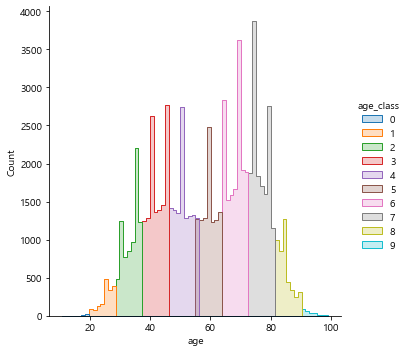

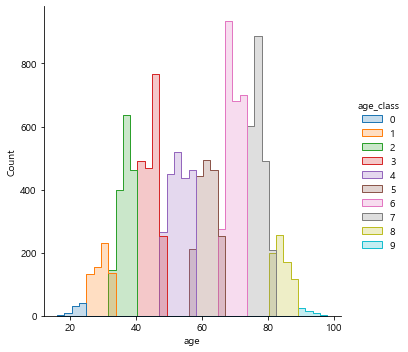

In [25]:
train['age'] = train['year'] - train['year_born']
train['age_class'] = pd.cut(train['age'], 10, labels=['0','1','2','3','4','5','6','7','8','9'])
sns.displot(train, x='age', hue='age_class', element='step')

test['age'] = test['year'] - test['year_born']
test['age_class'] = pd.cut(test['age'], 10, labels=['0','1','2','3','4','5','6','7','8','9'])
sns.displot(test, x='age', hue='age_class', element='step')

# 나이를 나타내는 변수 'age' 생성 및 시각화 및 시각화

In [26]:
train=train.drop(['year','year_born','wave','age'], axis=1)
test=test.drop(['year','year_born','wave','age'], axis=1)
# 필요 없는 변수 제거

train=train.drop(['income'],axis=1)

In [27]:
train.head()

,family_member,company_size,gender_1,gender_2,log_income,region_1,region_2,region_3,region_4,region_5,...,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,education_level_7,education_level_8,education_level_9,age_class
77530,1,1,0,1,6.428105,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,6
25998,2,0,1,0,7.811568,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,6
3626,4,1,0,1,7.612831,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
50176,1,0,0,1,3.912023,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,7
17894,6,1,1,0,7.973500,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,3


In [28]:
# income, wave, faimly_number, gender, region, education_level, age 로 데이터를 전처리함
# gender, region, education_level은 더미변수를 생성함

In [29]:
test.head()

,family_member,company_size,gender_1,gender_2,region_1,region_2,region_3,region_4,region_5,region_6,...,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,education_level_7,education_level_8,education_level_9,age_class
51802,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
24685,4,1,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
20910,3,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,5
24267,4,10,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
71797,2,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,6


In [30]:
y_train=train[['log_income']]
x_train=train.drop(['log_income'],axis=1)

# income을 예측하는 모형을 만드는 것이므로 income을 종속변수
# income을 제외한 나머지 변수는 독립변수로 x_train에 투입

In [31]:
y_train.head()

,log_income
77530,6.428105
25998,7.811568
3626,7.612831
50176,3.912023
17894,7.973500


In [32]:
x_train.head()

,family_member,company_size,gender_1,gender_2,region_1,region_2,region_3,region_4,region_5,region_6,...,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,education_level_7,education_level_8,education_level_9,age_class
77530,1,1,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,6
25998,2,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6
3626,4,1,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
50176,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,7
17894,6,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,3


In [33]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.15)

# train_test_split()함수를 이용하여 x_train과 y_train을 각각 x_train, x_validation, y_train, y_validation으로 split
# test_size는 test data가 전체 data의 약 15%이기에 validation 또한 15%로 하였음

In [34]:
print(x_train.shape,x_val.shape)
print(y_train.shape,y_val.shape)

(66636, 33) (11760, 33)
(66636, 1) (11760, 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly

train set score: 0.6073284209727781
valid set score: 0.608428982036286


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


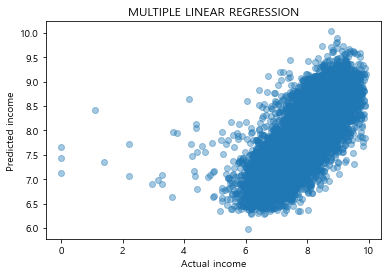

In [35]:
#여기서부터 모델 돌리기
LR = LinearRegression()
LR=LR.fit(x_train, y_train)
y_prediction = LR.predict(x_val)
y_test=y_prediction

print("train set score:", LR.score(x_train, y_train))
print("valid set score:",LR.score(x_val, y_val))

plt.scatter(y_val, y_prediction, alpha=0.4)
plt.title("MULTIPLE LINEAR REGRESSION")
plt.xlabel('Actual income')
plt.ylabel('Predicted income')
plt.show()

In [36]:
print("R-square:",LR.score(x_val, y_val))

R-square: 0.608428982036286


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [37]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor().fit(x_train, y_train)
print("R-squre:", tree.score(x_val, y_val))

R-squre: 0.6175056627231792


In [38]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

param_grid = [{'kernel': ['linear'], 'C': [0.1,1., 10., 30., 100.]},
              {'kernel': ['rbf'], 'C': [0.1,1., 10., 30.], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]}]

svm_reg = SVR(max_iter = 1000)

grid_search = GridSearchCV(svm_reg, param_grid, cv=10, scoring="neg_mean_squared_error", verbose=2)
grid_search.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 25 candidates, totalling 75 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ...............................C=0.1, kernel=linear; total time=   5.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ...............................C=0.1, kernel=linear; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ...............................C=0.1, kernel=linear; total time=   5.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ...............................C=1.0, kernel=linear; total time=   4.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ...............................C=1.0, kernel=linear; total time=   4.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ...............................C=1.0, kernel=linear; total time=   4.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ..............................C=10.0, kernel=linear; total time=   3.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ..............................C=10.0, kernel=linear; total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ..............................C=10.0, kernel=linear; total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ..............................C=30.0, kernel=linear; total time=   2.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ..............................C=30.0, kernel=linear; total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ..............................C=30.0, kernel=linear; total time=   2.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .............................C=100.0, kernel=linear; total time=   2.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .............................C=100.0, kernel=linear; total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .............................C=100.0, kernel=linear; total time=   2.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   9.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   9.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   9.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=0.1, gamma=0.03, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=0.1, gamma=0.03, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=0.1, gamma=0.03, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=0.3, kernel=rbf; total time=   9.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=0.3, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=0.3, kernel=rbf; total time=   9.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time=  10.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time=   9.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=1.0, gamma=0.01, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=1.0, gamma=0.03, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=1.0, gamma=0.03, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=1.0, gamma=0.03, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=0.1, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=0.1, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=0.1, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=0.3, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=0.3, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=0.3, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   9.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=   9.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=   9.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=   8.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=   8.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=   8.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=0.3, kernel=rbf; total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=0.3, kernel=rbf; total time=   7.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=0.3, kernel=rbf; total time=   7.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=1.0, kernel=rbf; total time=   6.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=1.0, kernel=rbf; total time=   6.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=10.0, gamma=1.0, kernel=rbf; total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=30.0, gamma=0.01, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=30.0, gamma=0.01, kernel=rbf; total time=   9.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=30.0, gamma=0.01, kernel=rbf; total time=   9.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=30.0, gamma=0.03, kernel=rbf; total time=   9.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=30.0, gamma=0.03, kernel=rbf; total time=   9.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END .....................C=30.0, gamma=0.03, kernel=rbf; total time=   9.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=0.1, kernel=rbf; total time=   8.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=0.1, kernel=rbf; total time=   8.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=0.1, kernel=rbf; total time=   8.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=0.3, kernel=rbf; total time=   7.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=0.3, kernel=rbf; total time=   7.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=0.3, kernel=rbf; total time=   7.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=1.0, kernel=rbf; total time=   6.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=1.0, kernel=rbf; total time=   6.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV] END ......................C=30.0, gamma=1.0, kernel=rbf; total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


GridSearchCV(cv=3, estimator=SVR(max_iter=1000),
             param_grid=[{'C': [0.1, 1.0, 10.0, 30.0, 100.0],
                          'kernel': ['linear']},
                         {'C': [0.1, 1.0, 10.0, 30.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [41]:
grid_search.best_params_

{'C': 10.0, 'gamma': 0.3, 'kernel': 'rbf'}

In [42]:
-grid_search.best_score_

0.6446372119904992